In [1]:
import pandas as pd
import datetime

file_path = "../data/plant_data.xlsx"
df = pd.read_excel(file_path)

In [2]:
df.head()


,S.No,Tag No,Area,Parameter,Unit,Low Limit,High Limit,00:00:00,01:00:00,02:00:00,...,22:00:00,23:00:00,Average,Total,Maximum,Minimum,Time(Max),Time(Min),HIGHER,LOWER
0,1,MW003,PV,ACTIVE POWER,MW,3.8,16.00,16.573622,16.233944,15.802419,...,16.439106,16.408161,16.110831,386.659935,17.474586,1.383017,2025-11-01 09:10:13,2025-11-01 19:49:13,1.474586,2.416983
1,2,FI101C,PV,MS COMPENSATED FLOW,TPH,40.7,74.00,70.271736,69.081223,68.17308,...,70.881912,70.877129,69.008482,1656.203575,75.507973,12.116806,2025-11-01 20:51:13,2025-11-01 19:35:13,1.507973,28.583194
2,3,LBA10FF001_TON,PV,MAIN STM FLOW 1 TPH,TNE/H,40.7,74.00,71.94091,72.355225,74.407379,...,72.565262,73.144958,71.821183,1723.708382,81.833214,24.840609,2025-11-01 23:43:13,2025-11-01 19:47:13,7.833214,15.859391
3,4,LBA10FF002_TON,PV,MAIN STM FLOW 2 TPH,TNE/H,40.7,74.00,72.151611,72.568062,74.616028,...,72.765938,73.347427,72.023619,1728.566868,82.010872,24.94537,2025-11-01 23:43:13,2025-11-01 19:47:13,8.010872,15.754630
4,5,LBA10FF001XJ01,PV,MAIN STM FLOW BOILER O/L,KG/S,NaN,20.55,19.983009,20.099869,20.666985,...,20.156923,20.318619,19.951046,478.8251,20.666985,16.405638,NaT,NaT,0.116985,NaN


In [3]:
df.shape

(500, 39)

In [4]:
df.isnull().sum()

S.No            0
Tag No          0
Area            0
Parameter       7
Unit            0
Low Limit     431
High Limit    273
00:00:00        0
01:00:00        0
02:00:00        0
03:00:00        0
04:00:00        0
05:00:00        0
06:00:00        0
07:00:00        0
08:00:00        0
09:00:00        0
10:00:00        0
11:00:00        0
12:00:00        0
13:00:00        0
14:00:00        0
15:00:00        0
16:00:00        0
17:00:00        0
18:00:00        0
19:00:00        0
20:00:00        0
21:00:00        0
22:00:00        0
23:00:00        0
Average         0
Total           0
Maximum         0
Minimum         0
Time(Max)     468
Time(Min)     468
HIGHER        273
LOWER         431
dtype: int64

IDENTIFY TIME COLUMNS

In [5]:
hour_cols = [col for col in df.columns if isinstance(col, datetime.time)]
print(len(hour_cols), "hour columns found")


24 hour columns found


CLEAN SENSOR VALUES

Force Everything to Numeric

In [6]:
df[hour_cols] = df[hour_cols].apply(pd.to_numeric, errors="coerce")
#If pandas cannot convert a value into a number, it will replace it with NaN
#“This value is missing, invalid, or unreadable as a number”

In [7]:
df = df[df[hour_cols].notna().any(axis=1)]




In [8]:
df[hour_cols].isna().sum()


00:00:00    0
01:00:00    0
02:00:00    0
03:00:00    0
04:00:00    0
05:00:00    0
06:00:00    0
07:00:00    0
08:00:00    0
09:00:00    0
10:00:00    0
11:00:00    0
12:00:00    0
13:00:00    0
14:00:00    0
15:00:00    0
16:00:00    0
17:00:00    0
18:00:00    0
19:00:00    0
20:00:00    0
21:00:00    0
22:00:00    0
23:00:00    0
dtype: int64

In [9]:
df[hour_cols] = df[hour_cols].apply(
    lambda row: row.fillna(row.mean()),
    axis=1
)


CLEAN METADATA

In [10]:
# Fix Missing Parameter Names
df["Parameter"] = df["Parameter"].ffill()


ENGINEERING LIMITS (CRITICAL FOR YOUR PROJECT)

Some rows don’t have:
Low Limit and
High Limit

In [11]:
# row means : The average value across all hours in each row
# row_stds : How much the values normally fluctuate around the mean


row_means = df[hour_cols].mean(axis=1)
row_stds = df[hour_cols].std(axis=1)

df["Low Limit"] = df["Low Limit"].fillna(row_means - 2 * row_stds)
df["High Limit"] = df["High Limit"].fillna(row_means + 2 * row_stds)


In [12]:
df[hour_cols].dtypes


00:00:00    float64
01:00:00    float64
02:00:00    float64
03:00:00    float64
04:00:00    float64
05:00:00    float64
06:00:00    float64
07:00:00    float64
08:00:00    float64
09:00:00    float64
10:00:00    float64
11:00:00    float64
12:00:00    float64
13:00:00    float64
14:00:00    float64
15:00:00    float64
16:00:00    float64
17:00:00    float64
18:00:00    float64
19:00:00    float64
20:00:00    float64
21:00:00    float64
22:00:00    float64
23:00:00    float64
dtype: object

<h1>REBUILD EVENT </h1>
Compute Max/Min Time from Data

In [13]:
def safe_idxmax(row):
    if row.notna().any():
        return row.idxmax()
    return "No Data"

def safe_idxmin(row):
    if row.notna().any():
        return row.idxmin()
    return "No Data"

df["Time(Max)"] = df[hour_cols].apply(safe_idxmax, axis=1)
df["Time(Min)"] = df[hour_cols].apply(safe_idxmin, axis=1)



<h1>REBUILD DEVIATION COUNTS</h1>
Your HIGHER and LOWER must be calculated from limits:

In [14]:
#You are measuring how often the system violated its normal operating band
def deviation_counts(row):
    values = row[hour_cols]
    return pd.Series([
        (values > row["High Limit"]).sum(),
        (values < row["Low Limit"]).sum()
    ])

df[["HIGHER", "LOWER"]] = df.apply(deviation_counts, axis=1)

#You are measuring how often the system violated its normal operating band
#You’re measuring operational risk and stability


In [15]:
print(df.isnull().sum())



S.No          0
Tag No        0
Area          0
Parameter     0
Unit          0
Low Limit     0
High Limit    0
00:00:00      0
01:00:00      0
02:00:00      0
03:00:00      0
04:00:00      0
05:00:00      0
06:00:00      0
07:00:00      0
08:00:00      0
09:00:00      0
10:00:00      0
11:00:00      0
12:00:00      0
13:00:00      0
14:00:00      0
15:00:00      0
16:00:00      0
17:00:00      0
18:00:00      0
19:00:00      0
20:00:00      0
21:00:00      0
22:00:00      0
23:00:00      0
Average       0
Total         0
Maximum       0
Minimum       0
Time(Max)     0
Time(Min)     0
HIGHER        0
LOWER         0
dtype: int64


<h2>Hourly Trend for Any Parameter</h2>

In [16]:
import matplotlib.pyplot as plt

def plot_daily_trend(df, param_name):
    row = df[df["Parameter"] == param_name].iloc[0]
    values = row[hour_cols].values

    # Convert time objects to strings (HH:MM)
    time_labels = [t.strftime("%H:%M") for t in hour_cols]

    plt.figure(figsize=(12, 5))
    plt.plot(time_labels, values, marker="o")
    plt.xticks(rotation=45)
    plt.title(f"Hourly Trend - {param_name}")
    plt.xlabel("Time")
    plt.ylabel(f"Value ({row['Unit']})")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


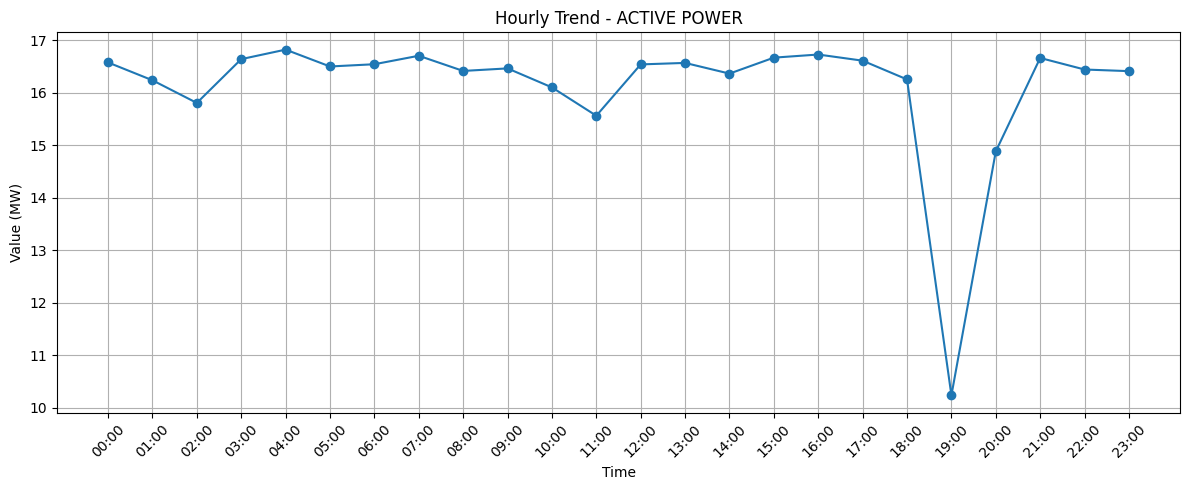

In [17]:
plot_daily_trend(df, df["Parameter"].iloc[0])


<p>Stable Operation (Most of the Day)

From 00:00 to ~17:00, the values stay around:

16–17 kW

This means:

System is running in a normal, steady state

Load is consistent

No major fluctuations</p>

Sudden Drop (Critical Event)

Around 18:00, there is a sharp dip to about:

10–11 kW

This is significant because:

It breaks the normal pattern

Likely represents:

⚠️ Load shedding

⚠️ Equipment shutdown

⚠️ Sensor fault

⚠️ Power supply issue

<h1>Trend with Normal Operating Bands</h1>

In [18]:
df["SEVERITY"] = df["HIGHER"] + df["LOWER"]
df["VARIABILITY"] = df[hour_cols].std(axis=1)
df["RANGE"] = df[hour_cols].max(axis=1) - df[hour_cols].min(axis=1)


In [19]:
df["SEVERITY_N"] = df["SEVERITY"] / df["SEVERITY"].max()
df["VAR_N"] = df["VARIABILITY"] / df["VARIABILITY"].max()
df["RANGE_N"] = df["RANGE"] / df["RANGE"].max()


In [20]:
df["INTEREST_SCORE"] = (
    0.5 * df["SEVERITY_N"] +
    0.3 * df["VAR_N"] +
    0.2 * df["RANGE_N"]
)


In [21]:
df[[
    "Parameter",
    "SEVERITY",
    "VARIABILITY",
    "RANGE",
    "INTEREST_SCORE"
]].head()


,Parameter,SEVERITY,VARIABILITY,RANGE,INTEREST_SCORE
0,ACTIVE POWER,20,1.323327,6.586317,0.385988
1,MS COMPENSATED FLOW,0,4.720745,24.555885,0.004987
2,MAIN STM FLOW 1 TPH,2,2.975447,15.403770,0.041598
3,MAIN STM FLOW 2 TPH,2,2.982831,15.442959,0.041606
4,MAIN STM FLOW BOILER O/L,3,0.823408,4.261347,0.058560


In [22]:
df.sort_values("INTEREST_SCORE", ascending=False).head(10)[
    ["Parameter", "SEVERITY", "VARIABILITY", "RANGE", "INTEREST_SCORE"]
]


,Parameter,SEVERITY,VARIABILITY,RANGE,INTEREST_SCORE
169,FEED WTR PMP2 I/L PR.,26,0.621396,2.157280,0.500564
166,FEED WTR P-1I/L PR.,26,0.620180,2.162494,0.500564
35,SH1.1 TEMP,25,9.505459,33.640289,0.489456
384,MAIN STEAM FLOW-2,1,429.686599,2335.433594,0.481701
468,MAIN STEAM FLOW-1,1,427.384932,2321.997070,0.479144
60,FUR TMP,24,12.168079,55.436584,0.473719
34,SH1.2 TEMP,24,11.689260,50.195251,0.472977
278,TURBINE SPEED,24,8.024854,31.224609,0.469114
140,FLOW SB STM VALUE,2,491.126584,1503.197464,0.467191
19,BLR DRM LVL TX,24,2.220026,11.047241,0.463841


In [23]:
import matplotlib.pyplot as plt

def plot_with_limits(df, param_name):
    row = df[df["Parameter"] == param_name].iloc[0]

    # Y values (numeric)
    values = row[hour_cols].values

    # X labels (convert datetime.time → "HH:MM")
    time_labels = [t.strftime("%H:%M") for t in hour_cols]

    plt.figure(figsize=(12, 5))
    plt.plot(time_labels, values, marker="o", label="Actual")
    plt.axhline(row["Low Limit"], linestyle="--", label="Low Limit")
    plt.axhline(row["High Limit"], linestyle="--", label="High Limit")

    plt.xticks(rotation=45)
    plt.title(f"Operating Band - {param_name}")
    plt.xlabel("Time")
    plt.ylabel(f"Value ({row['Unit']})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


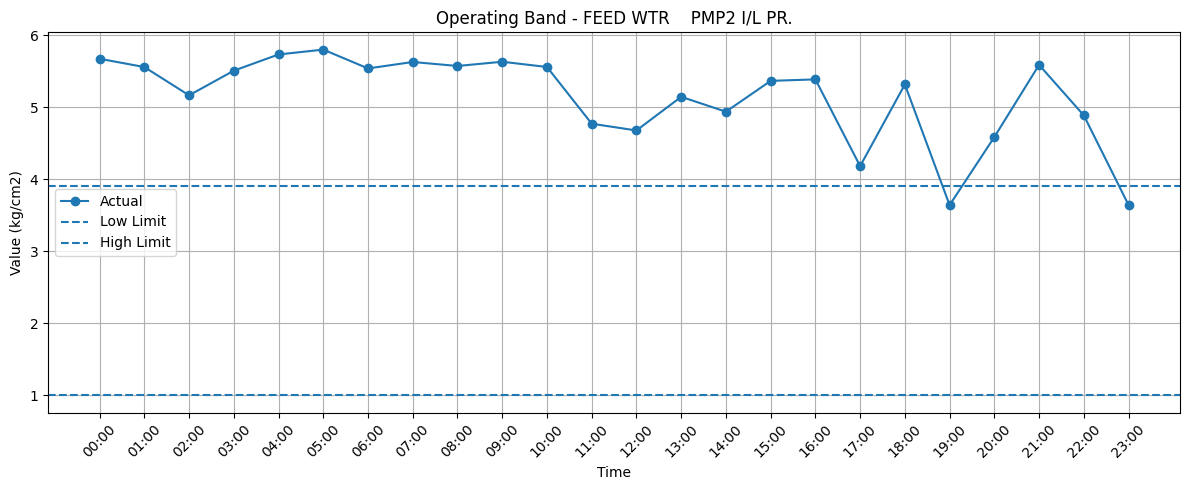

In [24]:
plot_with_limits(df, "FEED WTR    PMP2 I/L PR.")



Critical Low-Pressure Events (Anomalies)

You can clearly see drops below the Low Limit at:

🕔 ~17:00

🕖 ~19:00

🕚 ~23:00

These points indicate:

⚠️ Under-pressure conditions

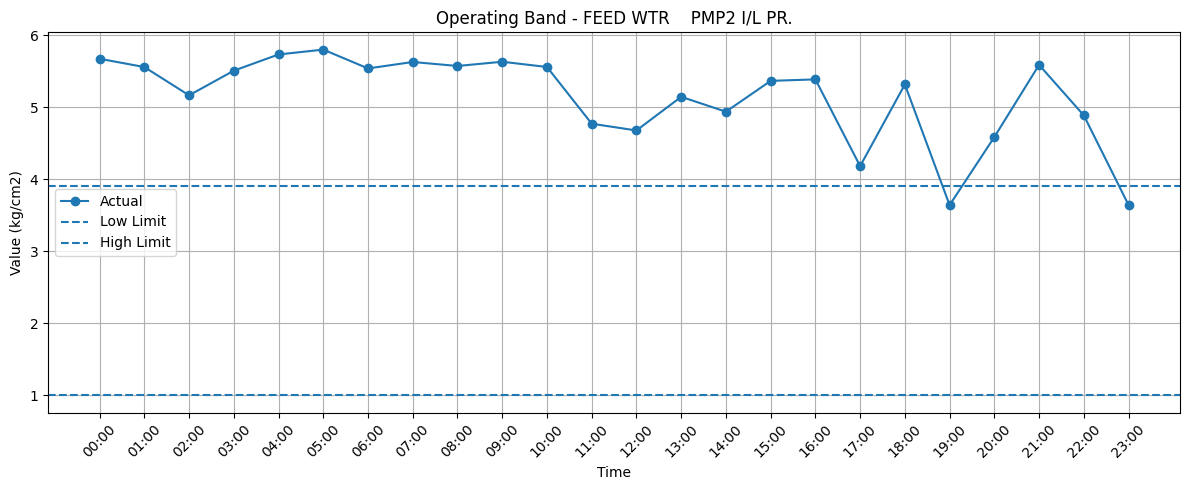

In [25]:
plot_with_limits(df, "FEED WTR    PMP2 I/L PR.")

The feed water pump inlet pressure stays normal for most of the day. However, in the evening, it drops below the safe level a few times. This suggests there may be temporary problems with the water supply or control system, so these periods should be checked and monitored more closely.

<h1>Anomaly Heatmap (Supervisor-Style View)</h1>

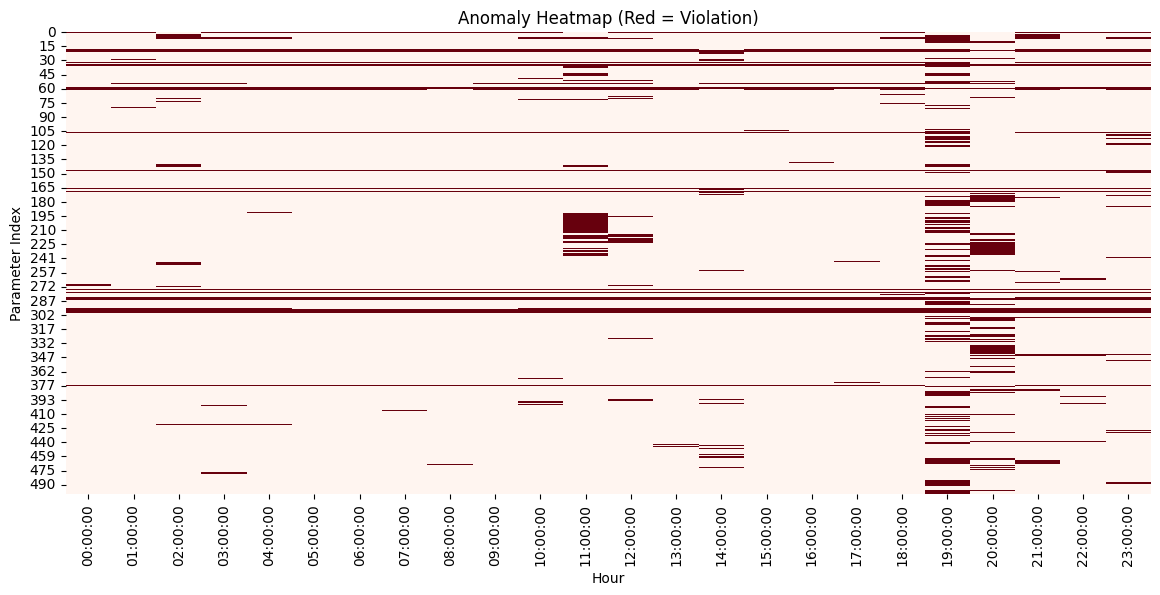

In [26]:
import seaborn as sns

anomaly_matrix = df[hour_cols].gt(df["High Limit"], axis=0) | \
                  df[hour_cols].lt(df["Low Limit"], axis=0)

plt.figure(figsize=(14, 6))
sns.heatmap(anomaly_matrix, cmap="Reds", cbar=False)
plt.title("Anomaly Heatmap (Red = Violation)")
plt.xlabel("Hour")
plt.ylabel("Parameter Index")
plt.show()


Top 10 most problematic parameters automatically

In [27]:
df["TOTAL_VIOLATIONS"] = df["HIGHER"] + df["LOWER"]
top10 = df.sort_values("TOTAL_VIOLATIONS", ascending=False).head(10)

top10[[
    "Parameter",
    "TOTAL_VIOLATIONS",
    "HIGHER",
    "LOWER",
    "Low Limit",
    "High Limit"
]]


,Parameter,TOTAL_VIOLATIONS,HIGHER,LOWER,Low Limit,High Limit
166,FEED WTR P-1I/L PR.,26,24,2,3.974322,1.000000
169,FEED WTR PMP2 I/L PR.,26,24,2,3.900463,1.000000
35,SH1.1 TEMP,25,24,1,436.725085,427.000000
285,TG EXHAUST PRESS 201B,24,0,24,-0.840000,-0.864897
275,PRESS FOR MN STM LINE,24,0,24,80.000000,93.000000
278,TURBINE SPEED,24,12,12,6805.000000,6805.000000
298,PRESS ALT CLR ACW IL,24,0,24,2.200000,3.500000
296,PR LUB OIL CLR ACW OL1,24,0,24,2.200000,3.500000
297,PR LUB OIL CLR ACW OL2,24,0,24,2.200000,3.500000
34,SH1.2 TEMP,24,23,1,526.621389,520.000000


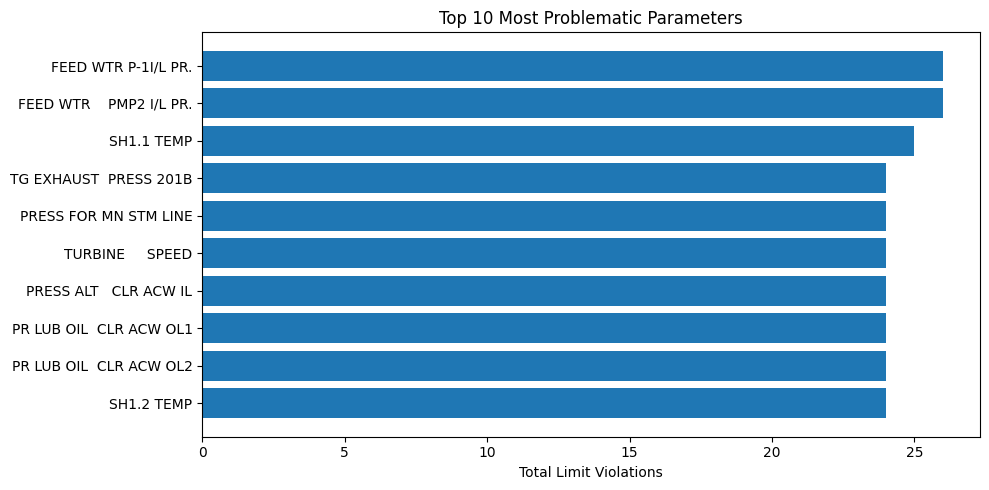

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.barh(top10["Parameter"], top10["TOTAL_VIOLATIONS"])
plt.title("Top 10 Most Problematic Parameters")
plt.xlabel("Total Limit Violations")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Which parameters go out of their safe limits the most during the day
These 10 are the biggest troublemakers

These parameters should be:Checked first by engineers or operators

In [29]:
long_df = df.melt(
    id_vars=["Parameter", "Low Limit", "High Limit", "HIGHER", "LOWER", "SEVERITY"],
    value_vars=hour_cols,
    var_name="Hour",
    value_name="Value"
)

# Convert time labels to numeric hour
long_df["Hour_Num"] = long_df["Hour"].apply(lambda t: t.hour)


In [33]:
import numpy as np
import datetime

def extract_features(df, hour_cols):
    feature_df = df.copy()
    values = feature_df[hour_cols]

    # Statistical features
    feature_df["F_MEAN"] = values.mean(axis=1)
    feature_df["F_STD"] = values.std(axis=1)
    feature_df["F_MIN"] = values.min(axis=1)
    feature_df["F_MAX"] = values.max(axis=1)
    feature_df["F_RANGE"] = feature_df["F_MAX"] - feature_df["F_MIN"]

    # Stability features
    feature_df["F_HIGHER"] = feature_df["HIGHER"]
    feature_df["F_LOWER"] = feature_df["LOWER"]
    feature_df["F_TOTAL_VIOL"] = feature_df["HIGHER"] + feature_df["LOWER"]
    feature_df["F_VIOL_PCT"] = feature_df["F_TOTAL_VIOL"] / len(hour_cols)

    # Safe time → hour extraction
    def get_hour(x):
        if x == "No Data" or pd.isna(x):
            return np.nan
        if isinstance(x, datetime.time):
            return x.hour
        if isinstance(x, str):
            return int(x.split(":")[0])
        return np.nan

    feature_df["F_TIME_MAX"] = feature_df["Time(Max)"].apply(get_hour)
    feature_df["F_TIME_MIN"] = feature_df["Time(Min)"].apply(get_hour)

    # Trend feature (simple linear slope)
    x = np.arange(len(hour_cols))

    def slope(row):
        y = row.values
        if np.isnan(y).all():
            return np.nan
        return np.polyfit(x, y, 1)[0]

    feature_df["F_TREND"] = values.apply(slope, axis=1)

    return feature_df


In [ ]:
features_df = extract_features(df, hour_cols)




In [35]:
feature_cols = [
    "F_MEAN", "F_STD", "F_MIN", "F_MAX", "F_RANGE",
    "F_HIGHER", "F_LOWER", "F_TOTAL_VIOL", "F_VIOL_PCT",
    "F_TIME_MAX", "F_TIME_MIN", "F_TREND"
]

features_df[feature_cols]



,F_MEAN,F_STD,F_MIN,F_MAX,F_RANGE,F_HIGHER,F_LOWER,F_TOTAL_VIOL,F_VIOL_PCT,F_TIME_MAX,F_TIME_MIN,F_TREND
0,16.110831,1.323327,10.231829,16.818146,6.586317,20,0,20,0.833333,4,19,-0.048040
1,69.008482,4.720745,47.705910,72.261795,24.555885,0,0,0,0.000000,21,19,-0.137337
2,71.821183,2.975447,59.003609,74.407379,15.403770,2,0,2,0.083333,2,19,-0.112490
3,72.023619,2.982831,59.173069,74.616028,15.442959,2,0,2,0.083333,2,19,-0.113102
4,19.951046,0.823408,16.405638,20.666985,4.261347,2,1,3,0.125000,2,19,-0.031102
...,...,...,...,...,...,...,...,...,...,...,...,...
495,94321.310221,114.427099,94133.585938,94504.445312,370.859375,0,0,0,0.000000,23,0,16.179752
496,0.613995,0.103927,0.504725,0.826931,0.322206,2,0,2,0.083333,19,9,0.007515
497,0.728191,0.021563,0.658952,0.766323,0.107371,0,1,1,0.041667,2,19,-0.000585
498,14.274172,1.327997,8.409671,15.064758,6.655087,0,1,1,0.041667,4,19,-0.058094


In [38]:

X=features_df
y = df[hour_cols].iloc[:, -1]  # Expected value


In [39]:

explore_df = X.copy()
explore_df["OUTPUT"] = y


In [42]:
explore_df.dtypes



S.No                  int64
Tag No                  str
Area                    str
Parameter               str
Unit                    str
Low Limit           float64
High Limit          float64
00:00:00            float64
01:00:00            float64
02:00:00            float64
03:00:00            float64
04:00:00            float64
05:00:00            float64
06:00:00            float64
07:00:00            float64
08:00:00            float64
09:00:00            float64
10:00:00            float64
11:00:00            float64
12:00:00            float64
13:00:00            float64
14:00:00            float64
15:00:00            float64
16:00:00            float64
17:00:00            float64
18:00:00            float64
19:00:00            float64
20:00:00            float64
21:00:00            float64
22:00:00            float64
23:00:00            float64
Average              object
Total                object
Maximum              object
Minimum              object
Time(Max)           